In [166]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load customer and transaction data
customers = pd.read_csv(r"C:\Users\ASUS\Documents\project_zeotap\Customers.csv")  # Assuming columns: CustomerID, CustomerName, Region, SignupDate
transactions = pd.read_csv(r"C:\Users\ASUS\Documents\project_zeotap\Transactions.csv")  # Assuming columns: TransactionID, CustomerID, ProductID, TransactionDate, Quantity, TotalValue, Price

# Feature engineering: Aggregate transaction data by CustomerID
transaction_aggregated = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    average_order_value=('TotalValue', 'mean'),
    recency=('TransactionDate', 'max')  # Get the most recent transaction date
).reset_index()


In [168]:
# Convert recency to number of days since the last purchase
transaction_aggregated['recency'] = pd.to_datetime('today') - pd.to_datetime(transaction_aggregated['recency'])
transaction_aggregated['recency'] = transaction_aggregated['recency'].dt.days

# Merge customer data with transaction features
data = pd.merge(customers, transaction_aggregated, on='CustomerID')

# Feature selection: Drop non-numeric and irrelevant columns
data_numeric = data.drop(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], axis=1)

In [170]:
# Scaling the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Experiment with different numbers of clusters (k=2 to k=10)
best_db_index = float('inf')
best_k = 0
db_indexes = []

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

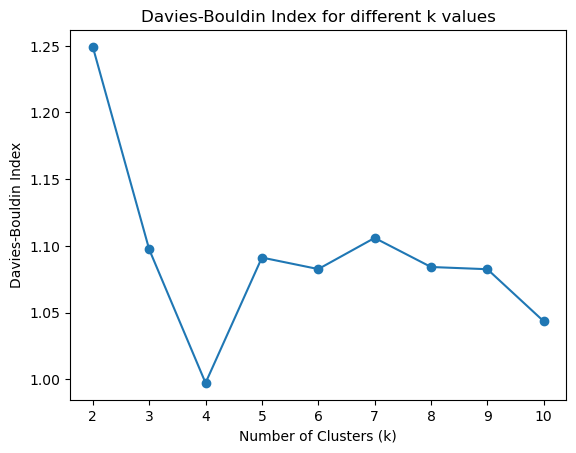

In [172]:
# Calculate Davies-Bouldin Index for k=2 to k=10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    db_index = davies_bouldin_score(data_scaled, kmeans.labels_)
    db_indexes.append(db_index)
    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k

# Plot DB Index values for different k values
plt.plot(range(2, 11), db_indexes, marker='o')
plt.title('Davies-Bouldin Index for different k values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [174]:
# Run KMeans with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [176]:
# Add cluster labels to the dataset
data['Cluster'] = clusters

# Visualize the clusters using PCA for 2D plot
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

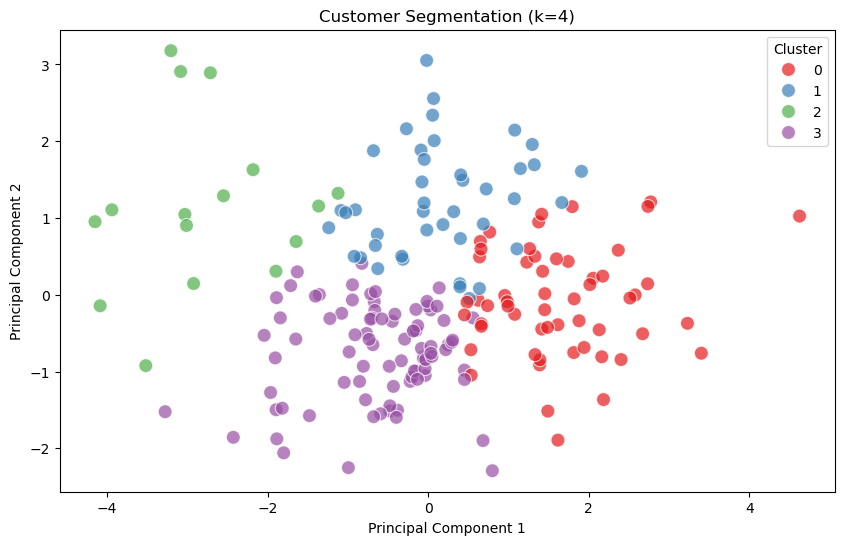

In [178]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='Set1', s=100, alpha=0.7)
plt.title(f'Customer Segmentation (k={best_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()



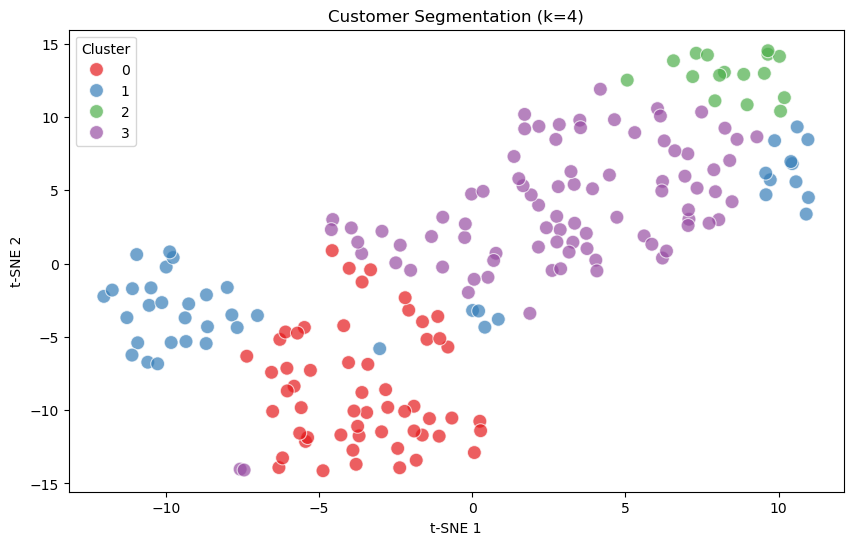

In [180]:
# Alternatively, use t-SNE for better separation
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=data['Cluster'], palette='Set1', s=100, alpha=0.7)
plt.title(f'Customer Segmentation (k={best_k})')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()